# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

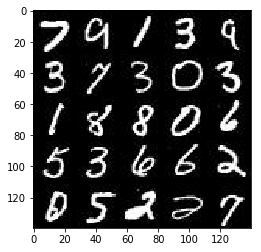

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

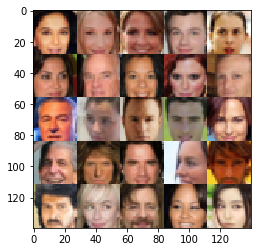

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder( tf.float32, ( None, image_width, image_height, image_channels ), name = "input_real" )
    inputs_z = tf.placeholder( tf.float32, ( None, z_dim ), name = "input_z" )
    learning_rate = tf.placeholder( tf.float32, name = "learn_rate" )
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        x1 = tf.layers.conv2d( images, 64, 5, strides=2, padding = "same" )
        x1 = tf.maximum( alpha*x1, x1 )
        
        x2 = tf.layers.conv2d( x1, 128, 5, strides=2, padding = "same" )
        x2 = tf.layers.batch_normalization( x2, training = True )
        x2 = tf.maximum( alpha*x2, x2 )
        
        x3 = tf.layers.conv2d( x2, 256, 5, strides=2, padding = "same" )
        x3 = tf.layers.batch_normalization(x2, training = True )
        x3 = tf.maximum( alpha*x3, x3 )
        
        flatten = tf.reshape( x3, ( -1, 4*4*256 ) )
        logits = tf.layers.dense( flatten, 1 )
        output = tf.sigmoid( logits )
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense( z, 7*7*512 )
        x1 = tf.reshape( x1, (-1, 7, 7, 512) )
        x1 = tf.layers.batch_normalization( x1, training = is_train )
        x1 = tf.maximum( alpha*x1, x1 )
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 5, strides = (2, 2), padding = "same" )
        x2 = tf.layers.batch_normalization( x2, training = is_train )
        x2 = tf.maximum( alpha*x2, x2 )
        
        x3 = tf.layers.conv2d_transpose( x2, 128, 5, strides = (2, 2), padding = "same" )
        x3 = tf.layers.batch_normalization( x3, training = is_train )
        x3 = tf.maximum( alpha*x3, x3 )
        
        # Output layer
        logits = tf.layers.conv2d_transpose( x3, out_channel_dim, 5, strides = (1, 1), padding = "same" )        
        output = tf.tanh( logits )
        
    return output 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator( input_z, out_channel_dim, is_train = True )
    disc_model_real, disc_logits_real = discriminator( input_real, reuse = False )
    disc_model_fake, disc_logits_fake = discriminator( gen_model, reuse = True )

    disc_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = disc_logits_real, 
                                                                    labels = tf.ones_like( disc_model_real ) ) )
    disc_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = disc_logits_fake, 
                                                                    labels = tf.zeros_like( disc_model_fake ) ) )
    disc_loss = disc_loss_real + disc_loss_fake
    
    gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = disc_logits_fake, 
                                                                    labels = tf.ones_like( disc_model_fake ) ) )
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    
    d_vars = [ var for var in t_vars if var.name.startswith( "discriminator" ) ]
    g_vars = [ var for var in t_vars if var.name.startswith( "generator" ) ]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer( learning_rate, beta1 = beta1 ).minimize( d_loss, var_list = d_vars )
        g_train_opt = tf.train.AdamOptimizer( learning_rate, beta1 = beta1 ).minimize( g_loss, var_list = g_vars )
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs( width, height, channels, z_dim )
    
    d_loss, g_loss = model_loss( input_real, input_z, channels )
    d_opt, g_opt = model_opt( d_loss, g_loss, learn_rate, beta1 )
    
    n_steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                
                n_steps += 1
                
                batch_z = np.random.uniform( -1, 1, size = ( batch_size, z_dim ) )

                _ = sess.run( d_opt, feed_dict = { input_real: batch_images, 
                                                   input_z: batch_z, learn_rate: learning_rate } )
                
                _ = sess.run( g_opt, feed_dict = { input_real: batch_images, 
                                                   input_z: batch_z, learn_rate: learning_rate } )

                if n_steps%50 == 0:
                    show_generator_output( sess, 16, input_z, channels, data_image_mode )

                if n_steps%10 == 0:
                    train_loss_d = d_loss.eval( { input_z: batch_z, input_real: batch_images } )
                    train_loss_g = g_loss.eval( { input_z: batch_z } )

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))                           

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6966... Generator Loss: 0.4262
Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 1.7425... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 0.9195


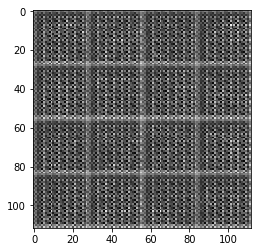

Epoch 1/2... Discriminator Loss: 0.8805... Generator Loss: 0.9414
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 0.8156
Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 1.2759


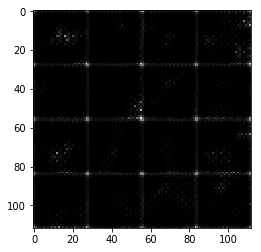

Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 1.5012
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.7323


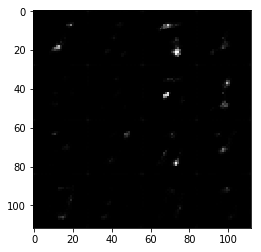

Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.6899


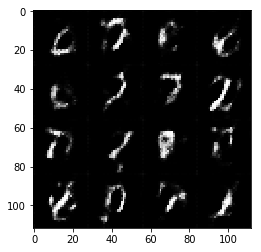

Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 0.6911
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.8139


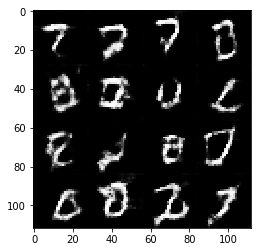

Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.6455


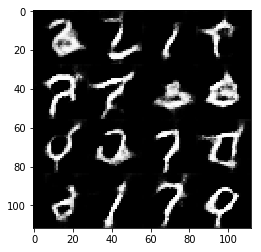

Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.6866
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.6714
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.7621


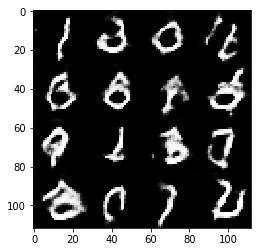

Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.6670


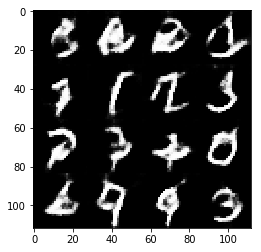

Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.7084
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.6452


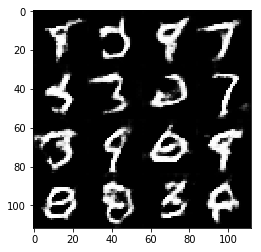

Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.7100
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.6716


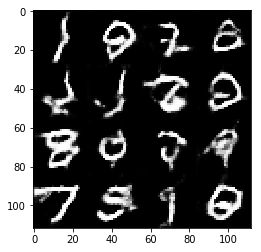

Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.6313
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.6122
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.6874


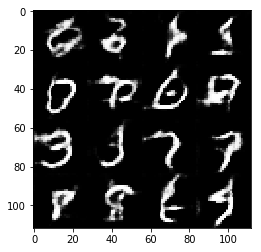

Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.6709


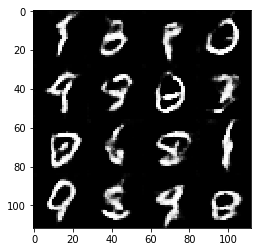

Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.6362


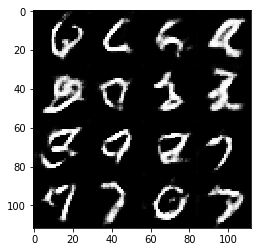

Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.6830
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.6478
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.7385
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.6820
Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.6875


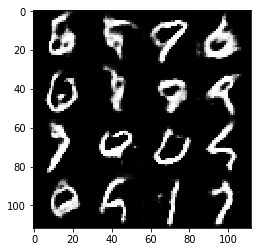

Epoch 1/2... Discriminator Loss: 1.3437... Generator Loss: 0.7039
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.6660
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.7047


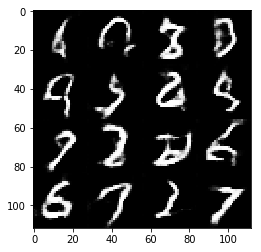

Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.6943
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.3460... Generator Loss: 0.6654


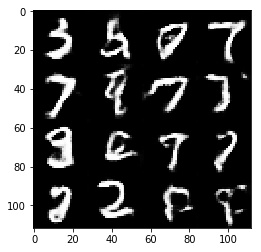

Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.7730


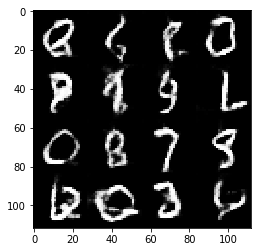

Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.6828


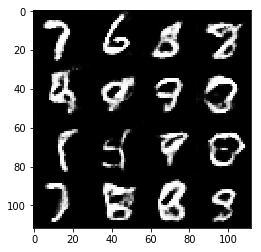

Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.6858


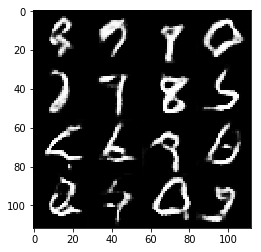

Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.7391
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.7219
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.7573
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.6459


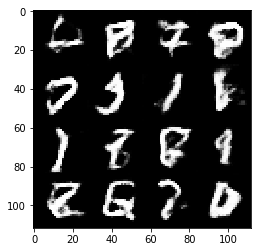

Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.3215... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 0.6572


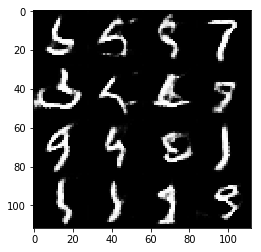

Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.6601
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 0.6826
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.6523


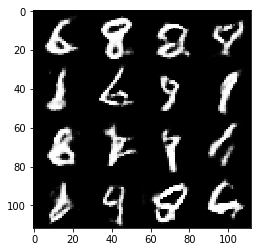

Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.8425
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.7592
Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 0.7246


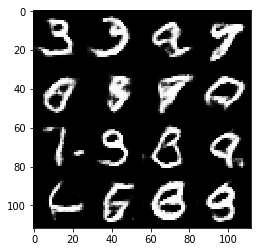

Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 0.7144
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.7161
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.7342
Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.2504... Generator Loss: 0.6998


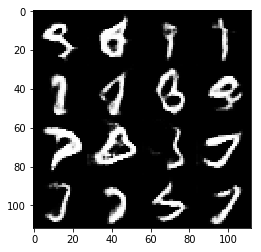

Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.2892... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 1.3244... Generator Loss: 0.6186
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.7112


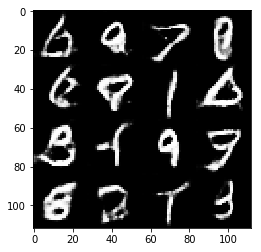

Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 0.7348
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.6862
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.5564


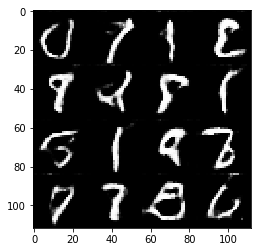

Epoch 2/2... Discriminator Loss: 1.2726... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.3034... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 1.2209... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.7132
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.6861


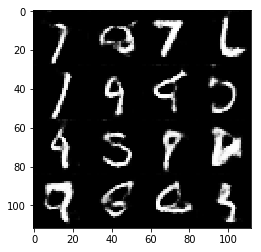

Epoch 2/2... Discriminator Loss: 1.2349... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.7276


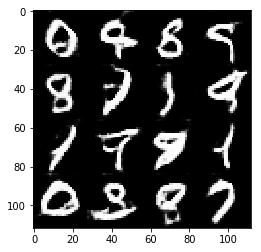

Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.2334... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.7272


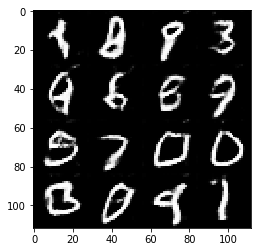

Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.8220


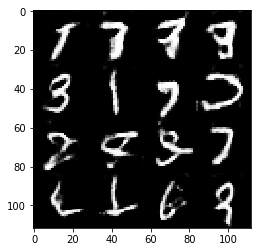

Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.7346


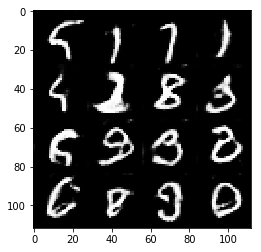

Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.2147... Generator Loss: 0.6550
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.6581


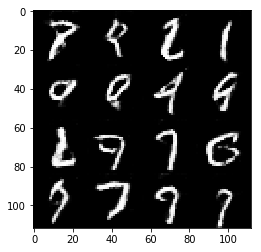

Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.8805
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.7509


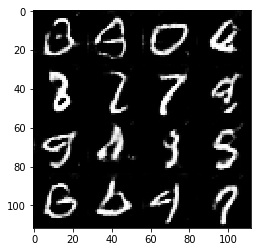

Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.8051


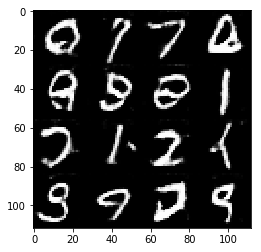

Epoch 2/2... Discriminator Loss: 1.2509... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 0.7365
Epoch 2/2... Discriminator Loss: 1.1851... Generator Loss: 0.8581
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.6278


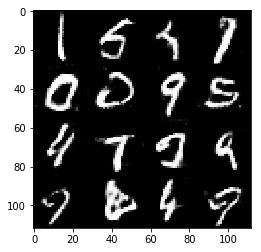

Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.8358
Epoch 2/2... Discriminator Loss: 1.1992... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.8434


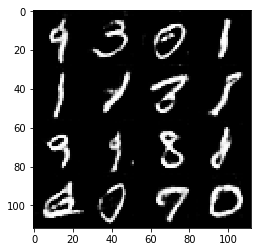

Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.9268
Epoch 2/2... Discriminator Loss: 1.2258... Generator Loss: 0.8679


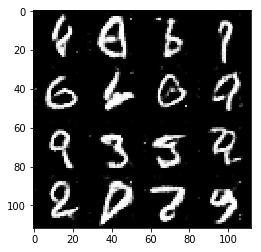

Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.6820
Epoch 2/2... Discriminator Loss: 1.2152... Generator Loss: 0.6674


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.5201... Generator Loss: 0.0665
Epoch 1/1... Discriminator Loss: 2.6290... Generator Loss: 0.1665
Epoch 1/1... Discriminator Loss: 2.0486... Generator Loss: 0.2988
Epoch 1/1... Discriminator Loss: 1.8804... Generator Loss: 0.3192


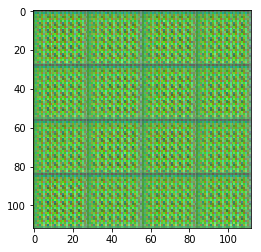

Epoch 1/1... Discriminator Loss: 1.9643... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.7422... Generator Loss: 0.3724
Epoch 1/1... Discriminator Loss: 1.7640... Generator Loss: 0.3463
Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 0.3750


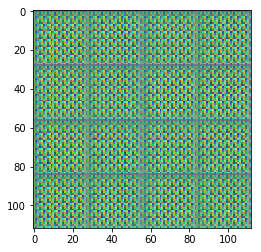

Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6501


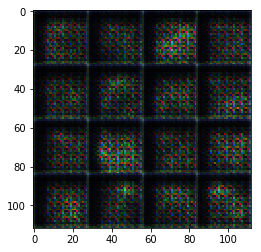

Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.7330


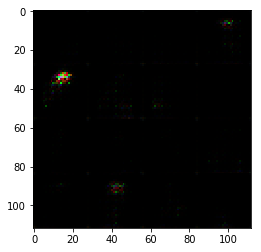

Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.8459


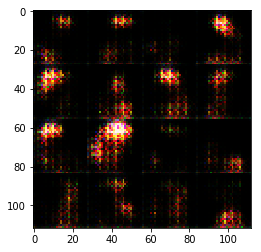

Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 0.9323


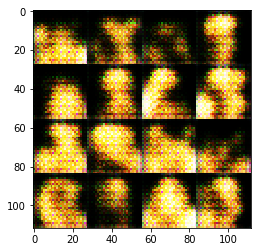

Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.1937


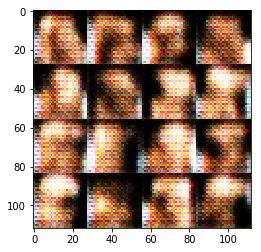

Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.2135


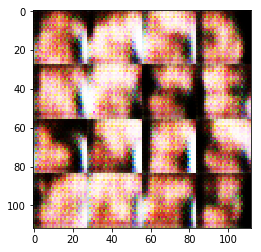

Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.9930
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.4794
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 0.6111... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 0.9604


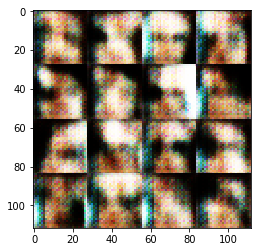

Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.1777
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 1.5158
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.1186
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.1675


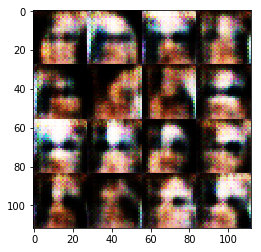

Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 2.3650
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 1.7297
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 1.3090


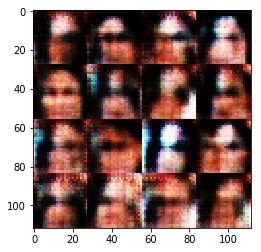

Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 1.9448
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.8393


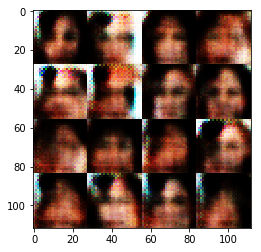

Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 1.8395
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8192


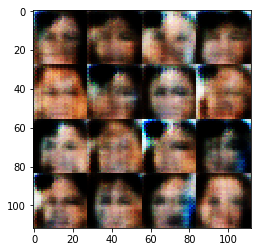

Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.4682
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6378


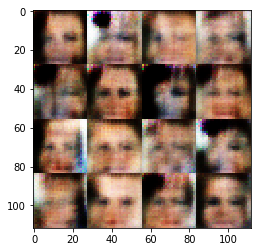

Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.8857


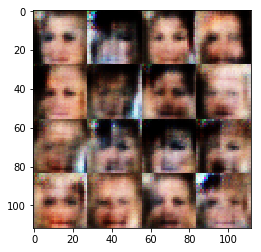

Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.4370
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.7012


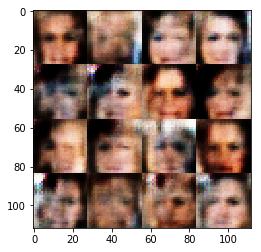

Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6359


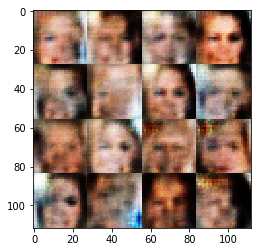

Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.2677
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.7971


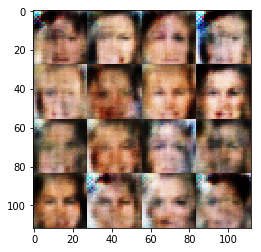

Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.7229


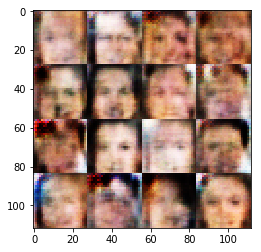

Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.7522


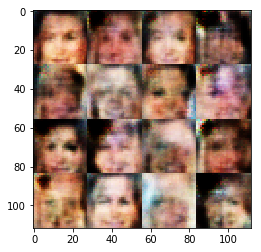

Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.3840
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5883


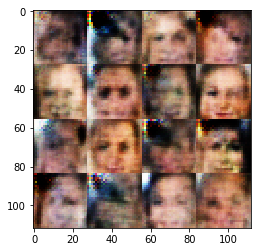

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9524


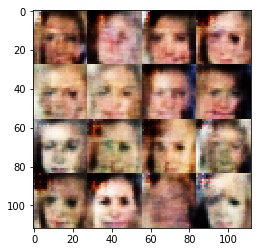

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.1684


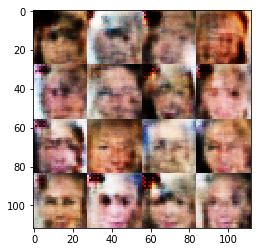

Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.7368


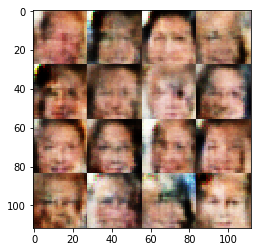

Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.1547


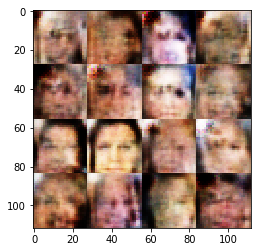

Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9930


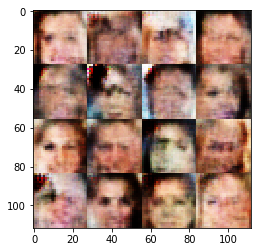

Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8292


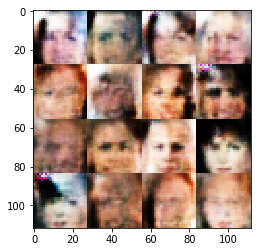

Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.6668


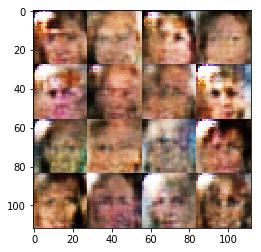

Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.9560


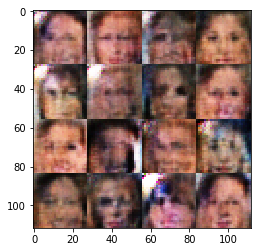

Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8673


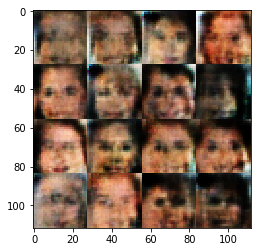

Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.7196


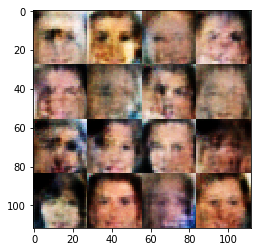

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.4441


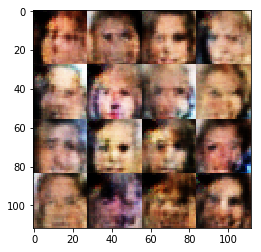

Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7483


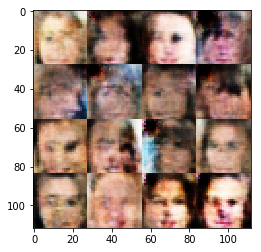

Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7073


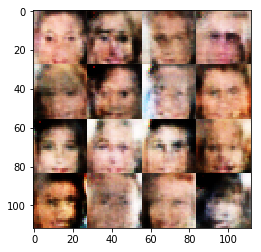

Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.6695


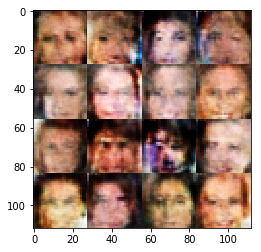

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9757


KeyboardInterrupt: 

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.